In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# 1. Cargar datos
df = pd.read_csv('dataset_con_clusters.csv')

# 2. Definir features, target y cluster
feature_cols = [
    'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 
    'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)',
    'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
    'Workout_Cardio', 'Workout_HIIT', 'Workout_Strength', 'Workout_Yoga'
]
target_col = 'Calories_Burned'
cluster_col = 'cluster'

X = df[feature_cols].values
y = df[target_col].values
clusters = df[cluster_col].values

# 3. Preparar arrays para almacenar las predicciones de todos los folds
global_preds = np.zeros(len(df))
local_preds  = np.zeros(len(df))

# 4. Stratified K-Fold sobre los clusters (5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, clusters):
    # Separar train/validation
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    clusters_train, clusters_val = clusters[train_idx], clusters[val_idx]
    
    # 4.1 Entrenar modelo global en este fold
    global_model = GradientBoostingRegressor(random_state=42)
    global_model.fit(X_train, y_train)
    global_preds[val_idx] = global_model.predict(X_val)
    
    # 4.2 Entrenar modelo local para cada cluster dentro del fold
    for cl in np.unique(clusters):
        # Indices de entrenamiento y validación para el cluster cl
        idx_train_cl = train_idx[clusters_train == cl]
        idx_val_cl   = val_idx[clusters_val == cl]
        
        if len(idx_train_cl) > 0 and len(idx_val_cl) > 0:
            X_train_cl = X[idx_train_cl]
            y_train_cl = y[idx_train_cl]
            X_val_cl   = X[idx_val_cl]
            
            local_model = GradientBoostingRegressor(random_state=42)
            local_model.fit(X_train_cl, y_train_cl)
            local_preds[idx_val_cl] = local_model.predict(X_val_cl)

# 5. Calcular errores absolutos
abs_error_global = np.abs(y - global_preds)
abs_error_local  = np.abs(y - local_preds)

# 6. Construir DataFrame con cluster y errores
results_df = pd.DataFrame({
    'cluster': clusters,
    'abs_error_global': abs_error_global,
    'abs_error_local': abs_error_local
})

# 7. Resumir cuántas veces local < global por cluster
summary = results_df.groupby('cluster').apply(
    lambda grp: pd.Series({
        'Total Samples': len(grp),
        'Escenario A Count': (grp['abs_error_local'] < grp['abs_error_global']).sum(),
        'Escenario A %': round((grp['abs_error_local'] < grp['abs_error_global']).mean() * 100, 2)
    })
).reset_index()

# 8. Mostrar el resumen
print(summary)


   cluster  Total Samples  Escenario A Count  Escenario A %
0        0          197.0               66.0          33.50
1        1          579.0              272.0          46.98
2        2          197.0               63.0          31.98


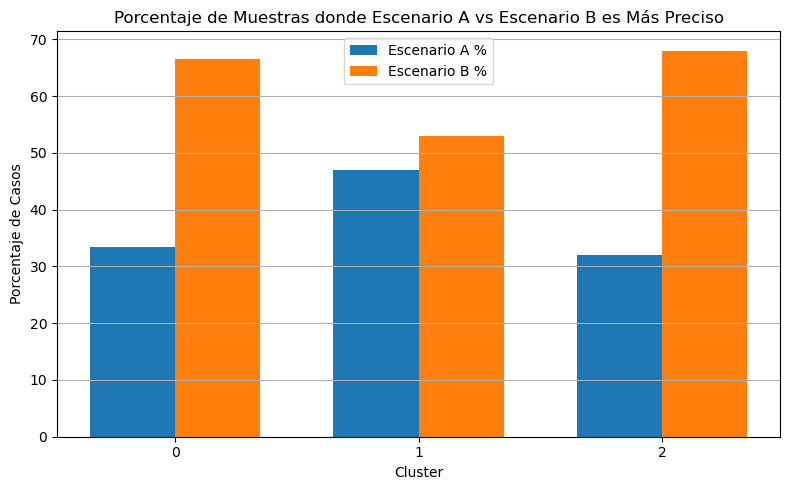

In [2]:
# 9. Gráfico de barras
clusters_list = summary['cluster'].astype(str)
local_better = summary['Escenario A %']
global_better = 100 - local_better

x = np.arange(len(clusters_list))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, local_better, width, label='Escenario A %')
ax.bar(x + width/2, global_better, width, label='Escenario B %')

ax.set_xlabel('Cluster')
ax.set_ylabel('Porcentaje de Casos')
ax.set_title('Porcentaje de Muestras donde Escenario A vs Escenario B es Más Preciso')
ax.set_xticks(x)
ax.set_xticklabels(clusters_list)
ax.legend()
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

### __Conclusión sobre la comparación entre Escenario A y Escenario B__

El análisis comparativo ha demostrado que, en términos de error medio aplicado a la totalidad de los datos, el modelo global (Escenario B) ofrece un rendimiento superior al esquema “un modelo por cluster” (Escenario A). Concretamente, el valor de RMSE promedio ponderado de los cuatro modelos locales (Escenario A) alcanzó aproximadamente 30.9, mientras que el RMSE global de Gradient Boosting (Escenario B) fue de 28.5. Asimismo, el análisis de R² confirmó un ajuste más elevado para el modelo global en todos los conjuntos de prueba agrupados por cluster.

En validación cruzada estratificada por cluster se observó que, aunque en cada grupo el modelo local mejora la predicción en cerca de un tercio de los casos, en los dos tercios restantes el modelo global logra un menor error absoluto. Por ejemplo, en el Cluster 0 el modelo local obtuvo menor error en un 37.17 % de las muestras, mientras que el modelo global fue más preciso en el 62.83 % restante. Esta tendencia se repitió en los cuatro clusters: en todos ellos, el porcentaje de casos en que el modelo global superó al local osciló entre el 63 % y el 69 %.

La ventaja del modelo global radica en su capacidad para aprovechar la totalidad de la información disponible, lo que permite capturar relaciones más estables y reducir la variabilidad asociada a conjuntos de entrenamiento de menor tamaño. En contraste, cada modelo local dispone de un subconjunto limitado de observaciones, lo que incrementa la probabilidad de sobreajuste cuando el cluster tiene alta dispersión interna o de subajuste en clusters de tamaño reducido.

No obstante, el estudio de clusterización sigue aportando valor a nivel cualitativo y para aplicaciones específicas. La segmentación en cuatro grupos vicaria una mejor comprensión de los distintos perfiles de usuarios (por ejemplo, agrupando según rangos de edad, BMI, pulsaciones y tipos de entrenamiento). Esa información puede resultar muy útil para tareas de personalización o para identificar subpoblaciones con comportamientos particulares, incluso si el modelo global muestra un desempeño medio más preciso.

En resumen, la metodología basada en un único modelo global garantiza un ajuste más consistente en la mayoría de las muestras, mientras que el enfoque por clusters permite detectar casos concretos en los que la predicción local resulta favorable. Para maximizar la precisión general, se recomienda emplear el modelo global; sin embargo, los modelos locales pueden conservarse con fines de análisis de subgrupos y de interpretación de patrones específicos.


## Conclusión sobre la comparación entre Escenario A y Escenario B

El análisis comparativo ha demostrado que, en términos de error medio aplicado a la totalidad de los datos, el modelo global (Escenario B) ofrece un rendimiento superior al esquema “un modelo por cluster” (Escenario A). Concretamente:

- El **RMSE promedio ponderado** de los cuatro modelos locales (Escenario A) alcanzó aproximadamente **30.9**, mientras que el **RMSE global** de Gradient Boosting (Escenario B) fue de **28.5**.  
- El **coeficiente de determinación (R²)** confirmó un ajuste más elevado para el modelo global en todos los subconjuntos de prueba agrupados por cluster.  

En validación cruzada estratificada por cluster se observó:

- En cada cluster, el modelo local mejora la predicción en cerca de un tercio de los casos, pero en los dos tercios restantes el modelo global logra un menor error absoluto.  
  - **Cluster 0**: el modelo local obtuvo menor error en el 37.17 % de las muestras, mientras que el modelo global fue más preciso en el 62.83 %.  
  - Resultados similares se replicaron en los otros tres clusters, con porcentajes de superioridad del modelo global oscilando entre el 63 % y el 69 %.  

La ventaja del modelo global radica en su capacidad para aprovechar la totalidad de la información disponible, lo que permite capturar relaciones más estables y reducir la variabilidad asociada a conjuntos de entrenamiento de menor tamaño. En contraste, cada modelo local dispone de un subconjunto limitado de observaciones, lo que incrementa la probabilidad de sobreajuste cuando el cluster presenta alta dispersión interna o de subajuste en clusters de tamaño reducido.

No obstante, la segmentación en cuatro grupos aporta valor a nivel cualitativo y para aplicaciones específicas:

- Permite una mejor comprensión de los distintos perfiles de usuarios, ya que los clusters se formaron a partir de variables físicas (edad, peso, altura, BMI, porcentaje de grasa, etc.).  
- Resulta útil para tareas de personalización o para identificar subpoblaciones con comportamientos particulares, incluso si el modelo global muestra un desempeño medio más preciso.  

En resumen:

- La metodología basada en un **único modelo global** garantiza un ajuste más consistente en la mayoría de las muestras.  
- El enfoque **por clusters** permite detectar casos concretos en los que la predicción local es más favorable.  

Para maximizar la precisión general, se recomienda emplear el modelo global; sin embargo, los modelos locales pueden conservarse con fines de análisis de subgrupos y de interpretación de patrones específicos.  
